In [1]:
from differences import ATTgt
from matplotlib import pyplot as plt
plt.rcParams["figure.dpi"] = 300
plt.rcParams['savefig.dpi'] = 300
from panel_utilities import get_value_variable_names, prepare_df_for_DiD
from stats_utilities import select_controls, test_balance, produce_summary_statistics
from figure_utilities import aggregate_by_event_time_and_plot, aggregate_by_time_and_plot
import pandas as pd



# Store paths.
analysis='group_0_crimes_500m'
INPUT_DATA = "../../data/03_cleaned/crime_analysis_monthly.parquet"
OUTPUT_FIGURES = f"../../output/group_0_crimes_warm_500m/figures"
OUTPUT_TABLES = f"../../output/group_0_crimes_warm_500m/tables"


# Read restricted sample panel dataset into memory.
df = pd.read_parquet(INPUT_DATA)

In [2]:
# Convert weekly panel to biweekly panel.
treatment_date_variable = 'latest_docket_month'
df = df.dropna(subset=treatment_date_variable)

# Generate value vars list and month to int dictionaries.
weekly_value_vars_crime, month_to_int_dictionary, int_to_month_dictionary = get_value_variable_names(df, analysis)

In [3]:
pre_pandemic_months = ['2019-04'
                       '2019-11',
                       '2019-12',
                       '2020-01',
                       '2020-02',
                       '2020-03']

df = df.loc[df['latest_docket_month'].isin(pre_pandemic_months), :]

In [4]:
covariates_exploration_df = select_controls(df=df, analysis=analysis,
                                            treatment_date_variable=treatment_date_variable,
                                            output_directory=OUTPUT_TABLES)
covariates_exploration_df

Dependent Variable  \
                                                                                             Change in Crime Incidents, April 2019-March 2020   
                                                 \emph{Independent Variable}                                                                    
Panel A: Pre-treatment Outcomes                  total_twenty_seventeen_group_0_crimes_500m                                      1.604795e-64   
                                                 pre_treatment_change_in_group_0_crimes_500m                                     1.059206e-09   
Panel B: Census Tract Characteristics            frac_coll_plus2010                                                              7.768688e-14   
                                                 job_density_2013                                                                5.582642e-40   
                                                 med_hhinc2016                                                                   7.895899e-17   
                                                 poor_share2010                                                                  4.120752e-03   
                                                 popdensity2010                                                                  6.991989e-05   
Panel C: Case Initiation                         for_cause                                                                       1.092310e-01   
                                                 no_cause                                                                        7.230618e-01   
                                                 non_payment                                                                     4.086131e-02   
Panel D: Defendant and Plaintiff Characteristics hasAttyD                                                                        9.074539e-01   
                                                 hasAttyP                                                                        5.286917e-01   
                                                 isEntityD                                                                       3.054689e-01   
                                                 isEntityP                                                                       8.132975e-03   

                                                                                                               
                                                                                             Treated Property  
                                                 \emph{Independent Variable}                                   
Panel A: Pre-treatment Outcomes                  total_twenty_seventeen_group_0_crimes_500m          0.423906  
                                                 pre_treatment_change_in_group_0_crimes_500m         0.264763  
Panel B: Census Tract Characteristics            frac_coll_plus2010                                  0.882054  
                                                 job_density_2013                                    0.619516  
                                                 med_hhinc2016                                       0.060960  
                                                 poor_share2010                                      0.598613  
                                                 popdensity2010                                      0.378280  
Panel C: Case Initiation                         for_cause                                           0.007280  
                                                 no_cause                                            0.000659  
                                                 non_payment                                         0.039447  
Panel D: Defendant and Plaintiff Characteristics hasAttyD                                            0.000001  
                                                 hasAttyP                                

In [5]:
balance_table, pre_treatment_covariates = test_balance(df, analysis, covariates_exploration_df, OUTPUT_TABLES)
balance_table

\
                                             Cases Won by Plaintiff   
Panel A Total Crime Incidents, 2017                     1197.305955   
        Change in Crime Incidents, 2017-2019            -165.188912   
Panel B Bachelor's degree, 2010                            0.314248   
        Job density, 2013                              17004.722095   
        Median household income, 2016                  47424.412731   
        Poverty rate, 2010                                 0.299440   
        Population density, 2010                       24015.060910   
Panel C Filing for nonpayment                              0.772074   
Panel D Plaintiff is entity                                0.841889   

                                             Difference in Cases Won by Defendant  \
                                                                       Unweighted   
Panel A Total Crime Incidents, 2017                                     40.913431   
        Change in Crime Incidents, 2017-2019                           -17.335329   
Panel B Bachelor's degree, 2010                                         -0.002291   
        Job density, 2013                                            -1608.562864   
        Median household income, 2016                                 3503.079398   
        Poverty rate, 2010                                               0.005917   
        Population density, 2010                                       909.471220   
Panel C Filing for nonpayment                                           -0.059702   
Panel D Plaintiff is entity                                             -0.055307   

                                                                              
                                              \emph{p}    Weighted  \emph{p}  
Panel A Total Crime Incidents, 2017           0.423906    6.835084  0.894557  
        Change in Crime Incidents, 2017-2019  0.264763   -0.589043  0.969579  
Panel B Bachelor's degree, 2010               0.882054    0.002188  0.888948  
        Job density, 2013                     0.619516  163.374079  0.960212  
        Median household income, 2016         0.060960  213.732551  0.904585  
        Poverty rate, 2010                    0.598613    0.001840  0.871768  
        Population density, 2010              0.378280  134.405111  0.896971  
Panel C Filing for nonpayment                 0.039447    0.007014  0.789616  
Panel D Plaintiff is entity                   0.024878    0.007352  0.734999

In [6]:
# Generate indicators for missing data.

# missing_indicators = add_missing_indicators(df, ['rent_twobed2015'], pre_treatment_covariates)

# Prepare df for use with the differences package.
df = df.reset_index()
df = prepare_df_for_DiD(df=df,
                        analysis=analysis,
                        treatment_date_variable=treatment_date_variable,
                        pre_treatment_covariates=pre_treatment_covariates,
                        missing_indicators=[],
                        value_vars=weekly_value_vars_crime,
                        period_to_int_dictionary=month_to_int_dictionary)

In [7]:
# Run DiD without conditioning on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_date_variable, freq='2W', base_period='universal')
result = att_gt.fit(formula=analysis, control_group='never_treated', n_jobs=-1)

Computing ATTgt [workers=10]  100%|████████████████████| 368/368 [00:07<00:00, 49.36it/s] 


-3.5451649427162293
-1.0930207270503804
-1.0568856788713932
1.5566089031325363


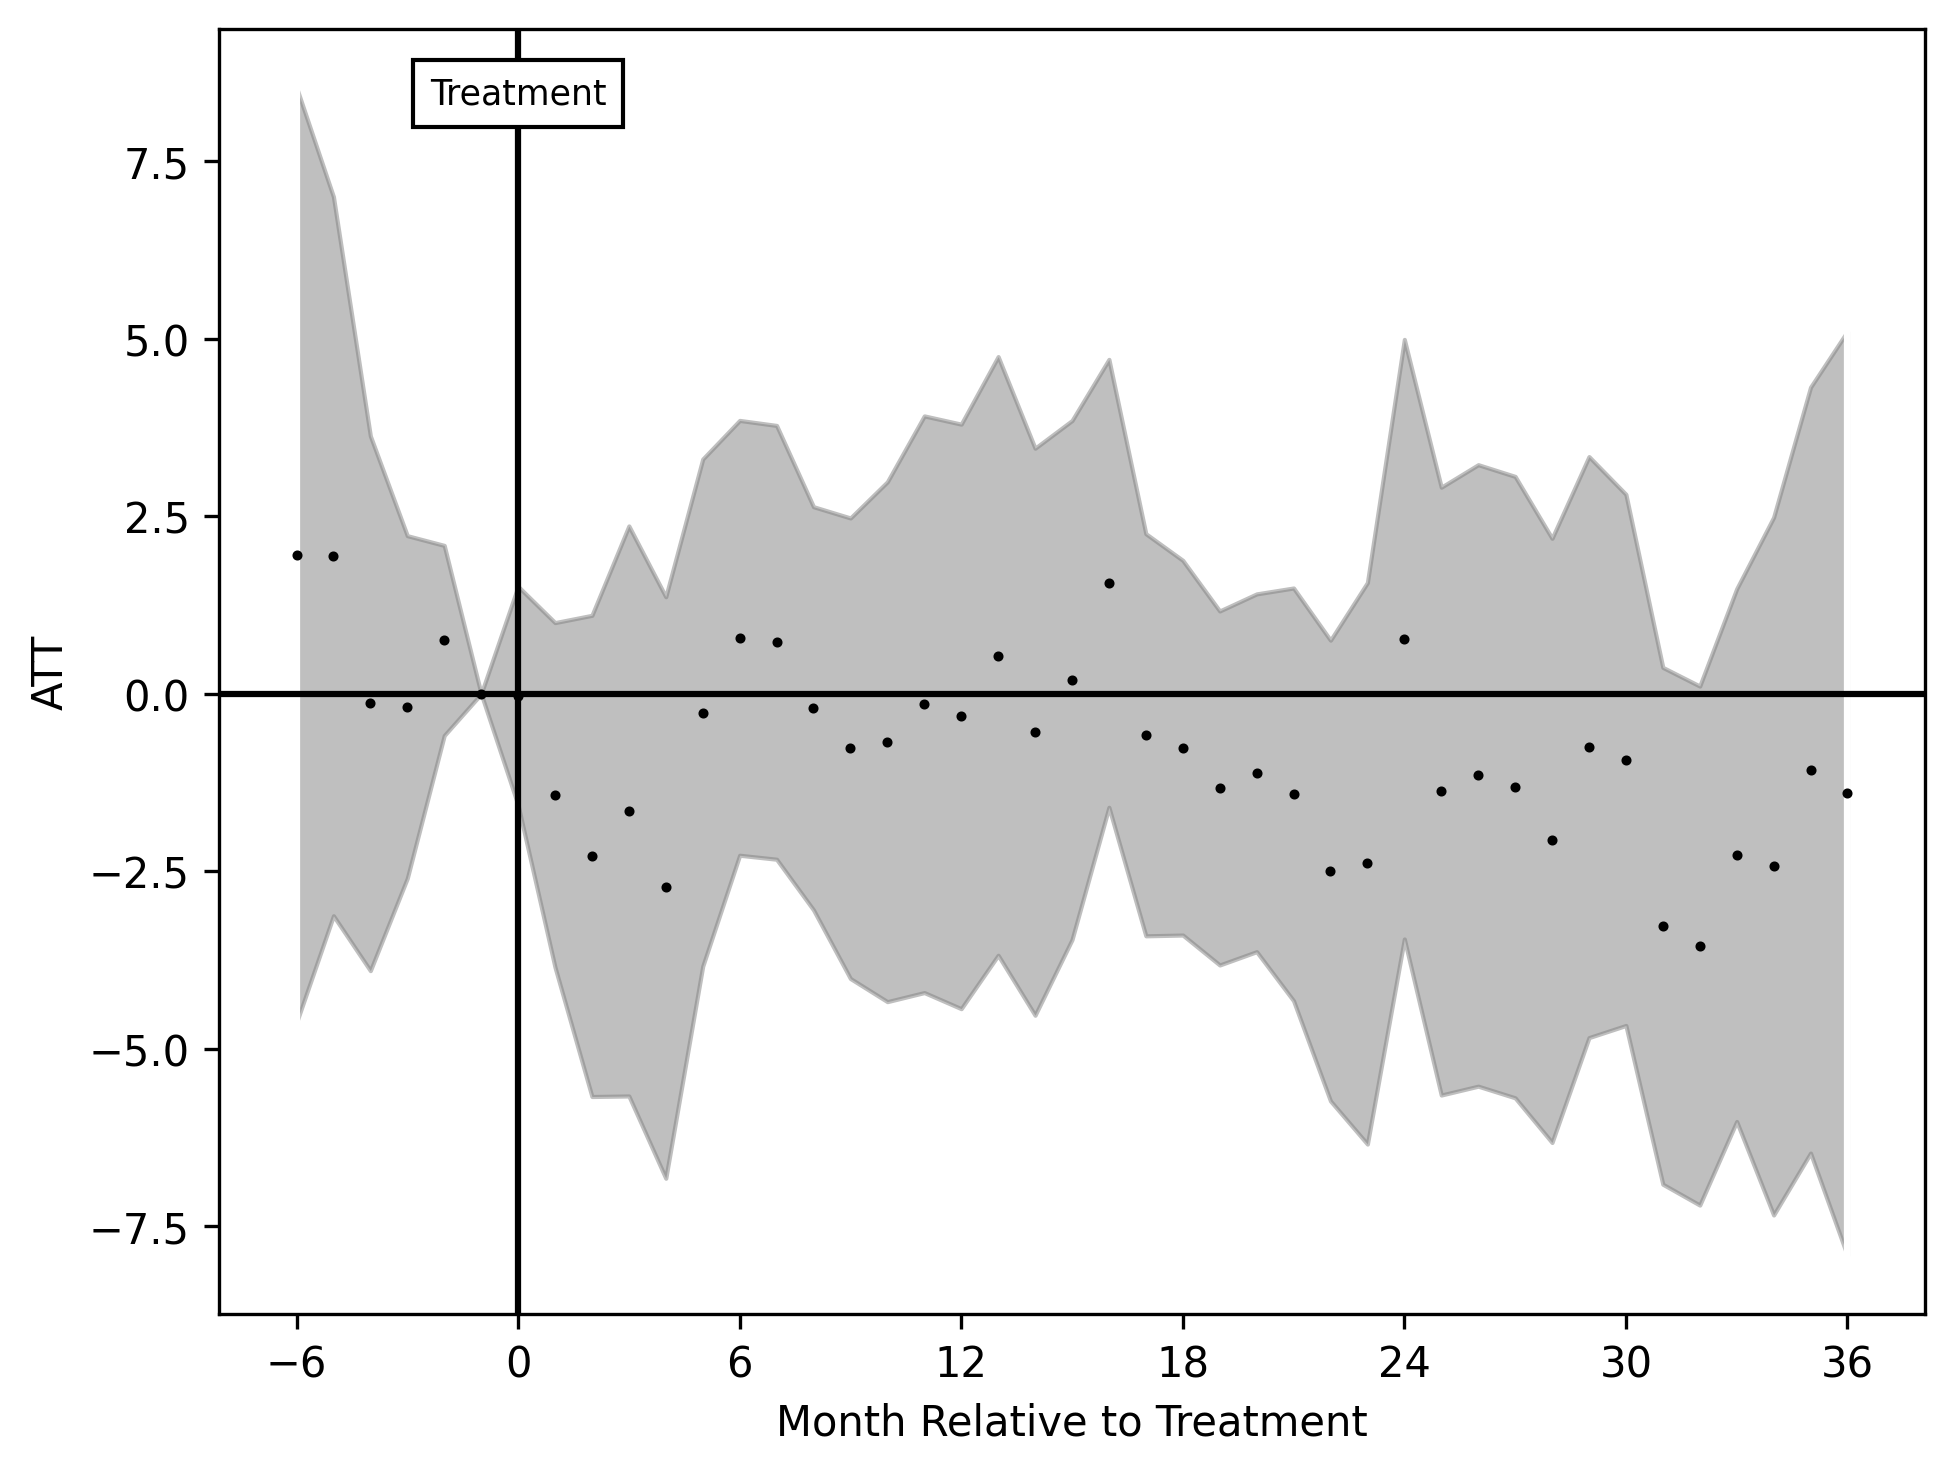

In [8]:
# Plot unconditional ATT(t-g)s on a long horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_unconditional_event_study_long_horizon.png",
                                 start_period=-6, end_period=36,
                                 title="",
                                 treatment_month_variable=treatment_date_variable, df=df)

In [9]:
# Run DiD conditional on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_date_variable, freq='M', base_period='universal')
formula = f'{analysis} ~ ' + '+'.join(pre_treatment_covariates)
result = att_gt.fit(formula=formula, control_group='never_treated', n_jobs=-1, progress_bar=True)

Computing ATTgt [workers=10]  100%|████████████████████| 368/368 [00:16<00:00, 22.69it/s]


-3.316131324638161
-1.2294391557781195
-1.1835585537592594
0.7043122717113697


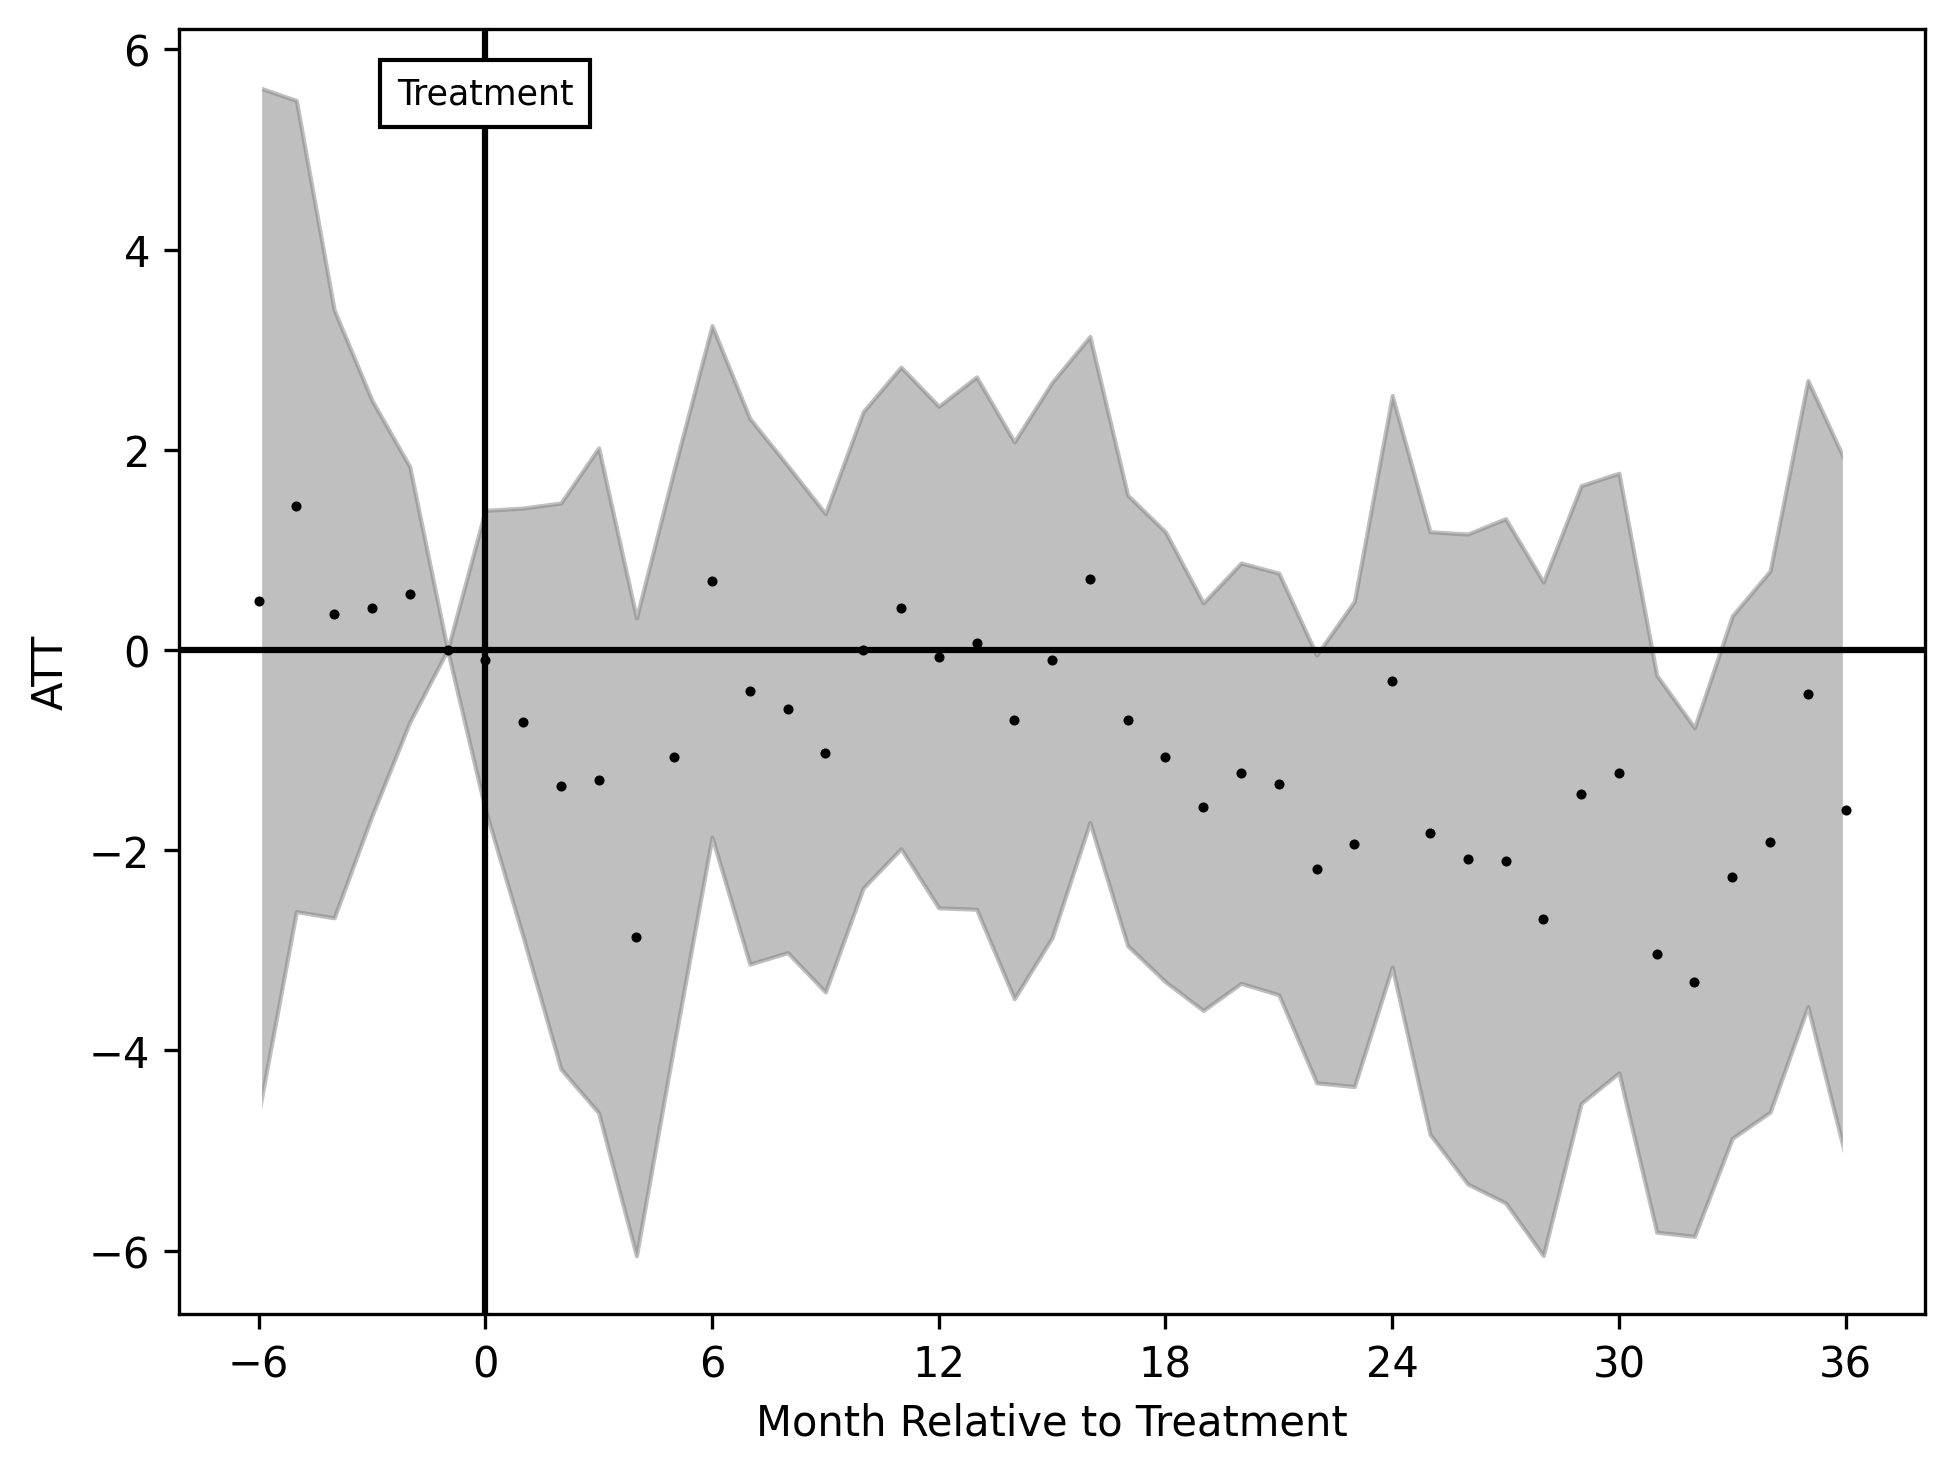

In [10]:
# Plot D.R. ATT(t-g)s on a long horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_dr_event_study_long_horizon.png", start_period=-6,
                                 end_period=36,
                                 title="",
                                 treatment_month_variable=treatment_date_variable, df=df)